In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import xgcm
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea
import fsspec
import zarr

from finite_differences import *
from grid_utils import *
from heat_budgets import *



<Client: 'tcp://127.0.0.1:42701' processes=4 threads=8, memory=61.46 GiB>

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42701")
# client = Client()
client.ncores
client.restart()
client

In [2]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join('/efs_ecco','ameza')

# for access_mode = 's3_open_fsspec', need to specify the root directory 
# containing the jsons
jsons_root_dir = join('/efs_ecco','mzz-jsons')

access_mode = 's3_open_fsspec'

## access datasets needed for this tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4", \
                   "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
StartDate = '1991-01'
EndDate = '2018-12'
ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                            StartDate=StartDate,EndDate=EndDate,\
                                            mode=access_mode,\
                                            download_root_dir=ECCO_dir,\
                                            max_avail_frac=0.5,\
                                            jsons_root_dir=jsons_root_dir)

In [3]:
ds_3D = ds_dict["ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]
ds_GEOM = ds_dict["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"]

ccc_mask = xr.open_dataset("CCC_mask.nc")

<Figure size 500x500 with 0 Axes>

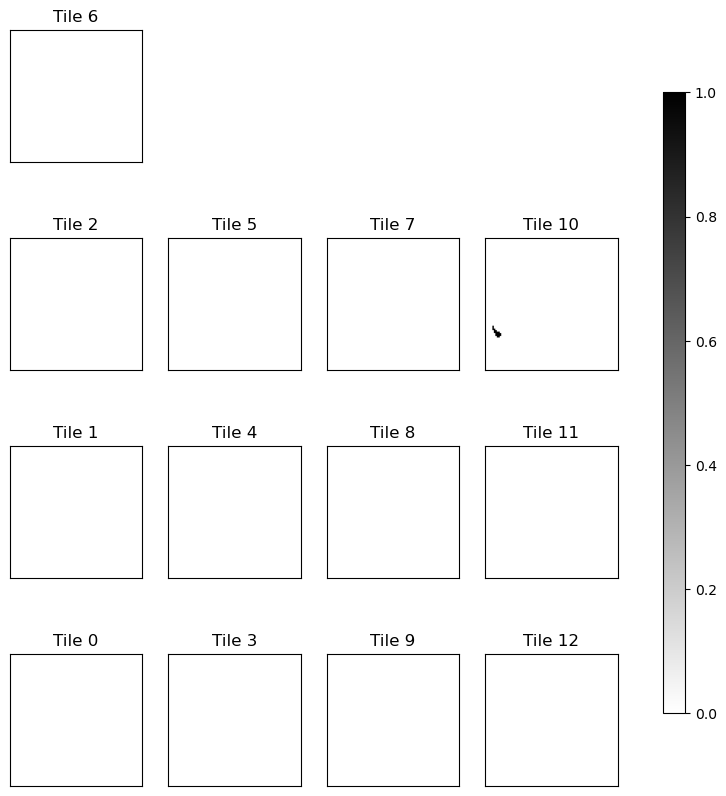

In [4]:
plt.figure(figsize=(5,5));
ecco.plot_tiles(enforce_pos_def_mask(ccc_mask["CCC_column_mask"]).isel(k = 0), show_colorbar=True, 
                cmin=0, cmax=1, 
                cmap="binary", 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=True);

In [5]:
# 1. Compute diagnostics --------------------------------------------------

# Column Hovmöller
da_hov = lateral_volume_average(
    ds_3D["THETA"], ds_GEOM, ccc_mask["CCC_column_mask"]
)

# Subsurface volume-average time series
da_subsurf = volume_average(
    ds_3D["THETA"], ds_GEOM, ccc_mask["CCC_sub_surf_mask"]
)

# Subsurface volume-average time series
da_subsurf_2D = vertical_volume_average(
    ds_3D["THETA"], ds_GEOM, ccc_mask["sub_surf_mask"]
)


# Surface volume-average time series
da_surf = volume_average(
    ds_3D["THETA"], ds_GEOM, ccc_mask["CCC_surf_mask"]
)

# Subsurface volume-average time series
da_surf_2D = vertical_volume_average(
    ds_3D["THETA"], ds_GEOM, ccc_mask["surf_mask"]
)



# 2. Rename to compact names with unit suffix ----------------------------

ds_ccs = xr.Dataset(
    {
        "ptemp_ccs_column_hov_degC": da_hov,
        "ptemp_ccs_subsurf_volavg_ts_degC": da_subsurf,
        "ptemp_ccs_surf_volavg_ts_degC": da_surf,
        "ptemp_ccs_subsurf_volavg_2D_ts_degC": da_subsurf_2D,
        "ptemp_ccs_surf_volavg_2D_ts_degC": da_surf_2D,
    }
)

# 3. Assign CF-compliant units & descriptions ----------------------------

attrs_map = {
    "ptemp_ccs_column_hov_degC": {
        "units": "degrees_Celsius",
        "long_name": (
            "Potential temperature Hovmöller (full depth–time) "
            "in the California Current System"
        ),
    },
    "ptemp_ccs_subsurf_volavg_ts_degC": {
        "units": "degrees_Celsius",
        "long_name": (
            "Subsurface (100 - 210 meters) volume-averaged potential temperature "
            "time series in the California Current System"
        ),
    },
    "ptemp_ccs_surf_volavg_ts_degC": {
        "units": "degrees_Celsius",
        "long_name": (
            "Surface (0 - 50 meters) volume-averaged potential temperature "
            "time series in the California Current System"
        ),
    },
    "ptemp_ccs_subsurf_volavg_2D_ts_degC": {
        "units": "degrees_Celsius",
        "long_name": (
            "Subsurface (100 - 210 meters) vertically volume-averaged potential temperature "
            "time series in the global ocean"
        ),
    },
    "ptemp_ccs_surf_volavg_2D_ts_degC": {
        "units": "degrees_Celsius",
        "long_name": (
            "Surface (0 - 50 meters) vertically volume-averaged potential temperature "
            "time series in the global ocean"
        ),
    },
}

for var_name, atts in attrs_map.items():
    ds_ccs[var_name] = ds_ccs[var_name].assign_attrs(**atts)

# 4. (Optional) Write to NetCDF ------------------------------------------

output_fname = "ptemp_ccs_timeseries.nc"
ds_ccs = ds_ccs.compute()

ds_ccs.to_netcdf(output_fname)
print(f"Wrote diagnostics to {output_fname!r}")


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 201.16 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Wrote diagnostics to 'ptemp_ccs_timeseries.nc'


In [6]:
def remove_seasonal_cycle(ds):
    # 1) compute the monthly climatology *preserving* each var’s attrs
    clim = ds.groupby("time.month") \
             .mean("time", keep_attrs=True)

    # 2) subtract, then restore your dataset‐level attrs
    anom = ds.groupby("time.month") - clim
    anom.attrs = ds.attrs
    return anom

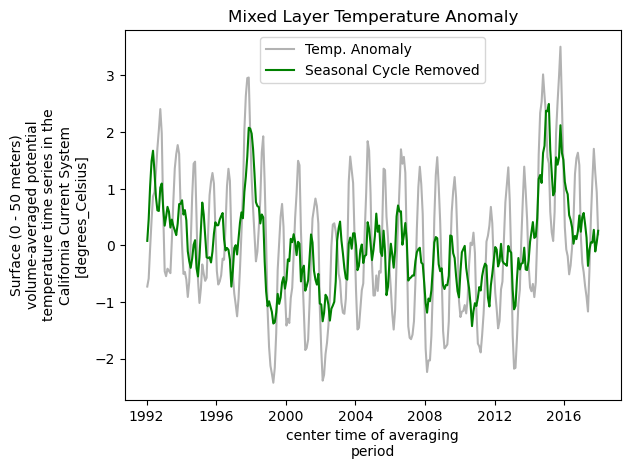

In [7]:
(ds_ccs["ptemp_ccs_surf_volavg_ts_degC"] - ds_ccs["ptemp_ccs_surf_volavg_ts_degC"].mean("time")).plot(label = "Temp. Anomaly", c = "k", alpha = 0.3)
remove_seasonal_cycle(ds_ccs["ptemp_ccs_surf_volavg_ts_degC"]).plot(label = "Seasonal Cycle Removed", c = "green")
plt.title("Mixed Layer Temperature Anomaly")
plt.legend()

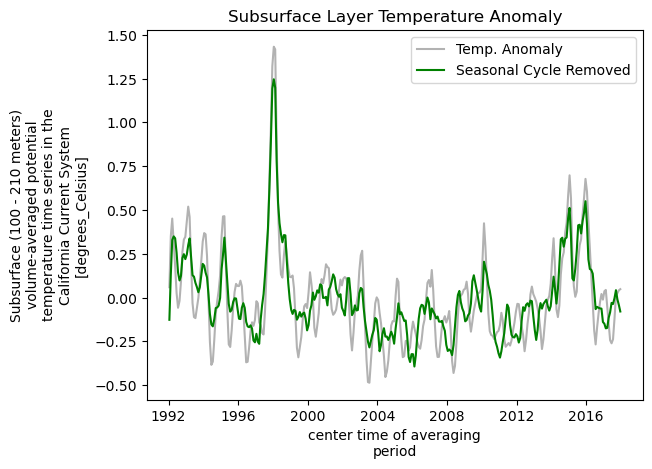

In [8]:
(ds_ccs["ptemp_ccs_subsurf_volavg_ts_degC"] - ds_ccs["ptemp_ccs_subsurf_volavg_ts_degC"].mean("time")).plot(label = "Temp. Anomaly", c = "k", alpha = 0.3)
remove_seasonal_cycle(ds_ccs["ptemp_ccs_subsurf_volavg_ts_degC"]).plot(label = "Seasonal Cycle Removed", c = "green")
plt.title("Subsurface Layer Temperature Anomaly")
plt.legend()

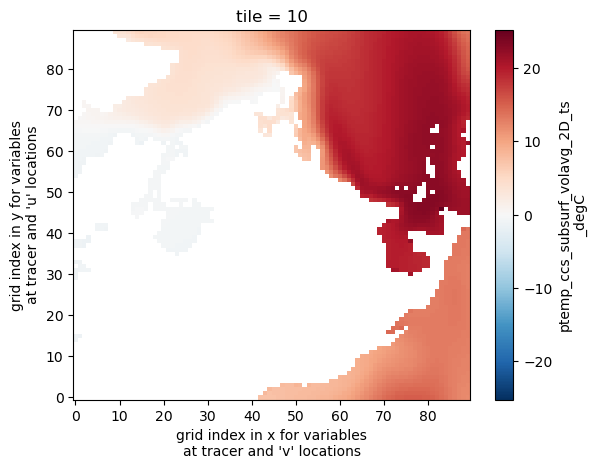

In [10]:
ds_ccs["ptemp_ccs_subsurf_volavg_2D_ts_degC"].isel(tile = 10).mean("time").plot()